In [26]:
!pip install sacremoses


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [60]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sacremoses import MosesTokenizer
import nltk
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
metadata_path = "../metadata"

In [3]:
# Create a dictionary of DataFrames, one for each language, with all the data provided
lang_data = {
    lang_dir: pd.concat(
        [pd.read_csv(f'{metadata_path}/{lang_dir}/cv-corpus-15.0-2023-09-08/{lang_dir}/{set_name}.tsv', delimiter="\t")
         for set_name in ["train", "test"]],
    )
    for lang_dir in os.listdir(metadata_path)
}

C:\Users\anais\AppData\Local\Temp\ipykernel_2376\2116275207.py:4: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  [pd.read_csv(f'{metadata_path}/{lang_dir}/cv-corpus-15.0-2023-09-08/{lang_dir}/{set_name}.tsv', delimiter="\t")


In [4]:
# Modify the dictionary of DataFrames to have also the duration
for lang in lang_data: 
    lang_data[lang] = pd.merge(
        lang_data[lang].rename(columns={'path': 'clip'}),
        pd.read_csv(f'{metadata_path}/{lang}/cv-corpus-15.0-2023-09-08/{lang}/clip_durations.tsv', delimiter="\t"),
    )

In [5]:
#Print the number of speakers for each language
print("number of speakers for each language")
for lang,df in lang_data.items():
    print(lang, df["client_id"].nunique())

number of speakers for each language
ar 982
de 12277
en 47861
es 10990
fr 12153
id 332
it 5098
ja 1073
lg 514
ru 2144
sw 956
ta 471
tr 1268
zh-CN 3454


In [6]:
#Print the total duration for each language
print("total duration for each language")
for lang,df in lang_data.items():
    print(lang, df["duration[ms]"].sum())

total duration for each language
ar 162160035
de 3341755685
en 6174878911
es 1720018728
fr 2820768179
id 42566295
it 975913433
ja 57698436
lg 466082146
ru 192763014
sw 305649144
ta 329813232
tr 149813327
zh-CN 215156913


In [7]:
#Create several DataFrames
genders = ["female", "male", None,"other"]
data = []

for gender in genders:
    for lang,df in lang_data.items():
        total_duration = df[df["gender"] == gender]["duration[ms]"].sum()
        num_speakers = df["client_id"].nunique()
        data.append([gender, lang, total_duration, num_speakers])
        
        #For each language and each gender : average, max, median, min number of recordings per speaker
        #One DataFrame for each language and each gender
        new_df = df.groupby(by="client_id")["duration[ms]"].agg(['max', 'min', 'mean', 'median'])
        #new_df.to_csv(f"{lang}_{gender}.csv")

# For each language and each genre : total duration of recordings, the number of different speakers
result_df = pd.DataFrame(data, columns=["Gender", "Language", "Total Duration", "Number of Speakers"])
result_df.head()


,Gender,Language,Total Duration,Number of Speakers
0,female,ar,26649792,982
1,female,de,256048399,12277
2,female,en,1211778903,47861
3,female,es,474956697,10990
4,female,fr,319672321,12153


In [8]:
#Question 3
filtered_data = [(lang, df[df["age"] == "nineties"]["client_id"].value_counts()) for lang, df in lang_data.items() if not df[df["age"] == "nineties"]["client_id"].value_counts().empty]

result_df = pd.DataFrame({
    "Language": [lang for lang, _ in filtered_data],
    "Max Number of Recordings per Speaker": [counts.max() for _, counts in filtered_data],
    "Total Number of Recordings": [counts.sum() for _, counts in filtered_data],
    "Max Proportion of Recordings per Speaker": [counts.max() / counts.sum() for _, counts in filtered_data]
})

result_df


,Language,Max Number of Recordings per Speaker,Total Number of Recordings,Max Proportion of Recordings per Speaker
0,ar,4,4,1.000000
1,de,50,50,1.000000
2,en,53,146,0.363014
3,es,57,79,0.721519
4,it,5,5,1.000000
5,ja,2,2,1.000000
6,lg,352,352,1.000000
7,zh-CN,1,1,1.000000


In [9]:
#Question 3 - suite 
#Print the max proportion of recordings per speaker according to the language
filtered_data = [(lang, df[df["age"] == "nineties"]["client_id"].value_counts()) for lang, df in lang_data.items() if not df[df["age"] == "nineties"]["client_id"].value_counts().empty]

result_df = pd.DataFrame({
    "Language": [lang for lang, _ in filtered_data],
    "Max Proportion of Recordings per Speaker": [counts.max() / counts.sum() for _, counts in filtered_data]
})


max_value = result_df["Max Proportion of Recordings per Speaker"].max()

filtered_result_df = result_df[result_df["Max Proportion of Recordings per Speaker"] == max_value]

filtered_result_df

,Language,Max Proportion of Recordings per Speaker
0,ar,1.0
1,de,1.0
4,it,1.0
5,ja,1.0
6,lg,1.0
7,zh-CN,1.0


In [10]:
#Question 4
#Print the differentes genders considered in the corpus
for lang,df in lang_data.items():
    print(lang, df["gender"].unique())

ar [nan 'female' 'male' 'other']
de ['male' nan 'female' 'other']
en [nan 'female' 'male' 'other']
es [nan 'male' 'female' 'other']
fr [nan 'male' 'female' 'other']
id [nan 'male' 'female' 'other']
it [nan 'male' 'female' 'other']
ja ['male' 'female' nan 'other']
lg [nan 'female' 'male']
ru [nan 'male' 'female' 'other']
sw ['female' nan 'male']
ta ['male' nan 'female']
tr ['male' nan 'female' 'other']
zh-CN [nan 'male' 'female' 'other']


In [11]:
#Question 4 - suite 
#Print the percentage of recordings for which no genre information is available
combined_df = pd.concat(lang_data.values())

nan_percentage = (combined_df["gender"].isna().mean() * 100)

print(f"Percentage of NaN in 'gender': {nan_percentage:.2f}%")

Percentage of NaN in 'gender': 30.21%


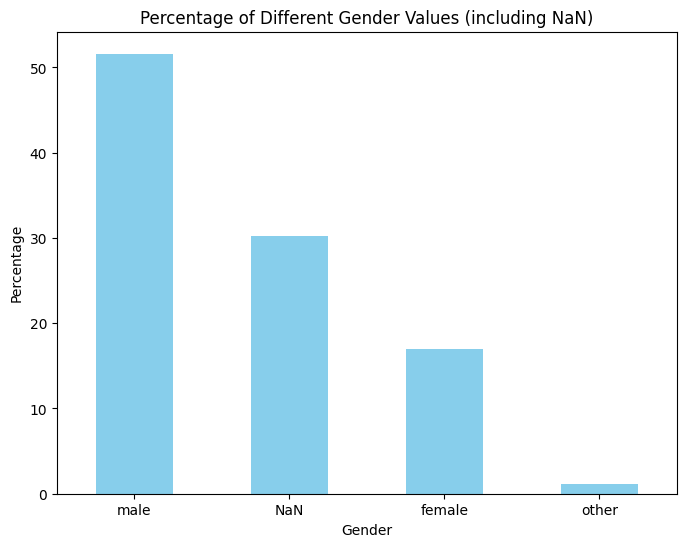

In [12]:
#Question 4 - suite 
#Print the gender distribution
# Create a MultiIndex to track the original language
dfs = [df.assign(Language=lang) for lang, df in lang_data.items()]
concatenated_df = pd.concat(dfs, ignore_index=True)
concatenated_df['gender'].fillna("NaN", inplace=True)

gender_counts = concatenated_df['gender'].value_counts(normalize=True) * 100

# Plot the percentages
plt.figure(figsize=(8, 6))
gender_counts.plot(kind='bar', color='skyblue')
plt.title('Percentage of Different Gender Values (including NaN)')
plt.xlabel('Gender')
plt.ylabel('Percentage')
plt.xticks(rotation=0)  
plt.show()



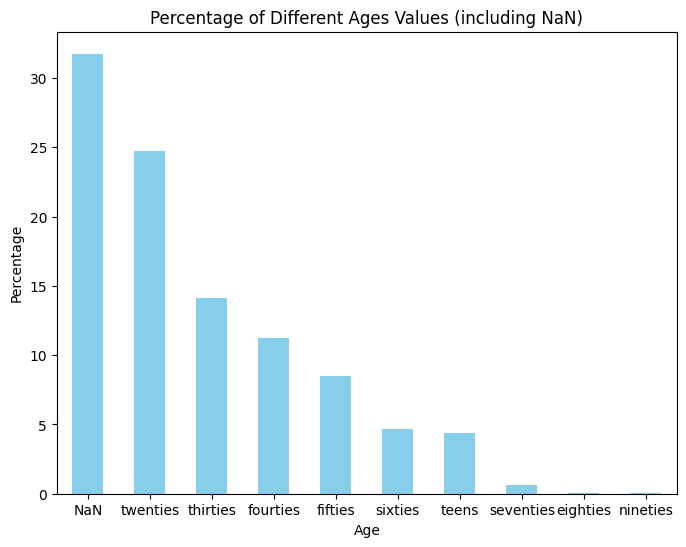

In [13]:
#Question 4 - suite 
#Print the age distribution
concatenated_df['age'].fillna("NaN", inplace=True)

age_counts = concatenated_df['age'].value_counts(normalize=True) * 100

# Plot the percentages
plt.figure(figsize=(8, 6))
age_counts.plot(kind='bar', color='skyblue')
plt.title('Percentage of Different Ages Values (including NaN)')
plt.xlabel('Age')
plt.ylabel('Percentage')
plt.xticks(rotation=0)  
plt.show()



In [14]:
#Question 5
#Print he 7 speakers who produced the most recordings for each language and each gender
grouped_df = concatenated_df.groupby(['Language', 'gender', 'client_id'])['clip'].count().reset_index()
sorted_df = grouped_df.sort_values(['Language', 'gender', 'clip'], ascending=[True, True, False])
top_speakers = sorted_df.groupby(['Language', 'gender']).head(7)
top_speakers.head()


,Language,gender,client_id,clip
74,ar,NaN,1ebda36c79c7942d2d10a68236599dd5be279fcf6f17ad...,2517
153,ar,NaN,3b941765a02cc4e9bdf5d8a99c3e3cc3b1ce3413911116...,2187
113,ar,NaN,2c1c6088204f735de177d61cd8aa000be8a060ef5357c5...,1939
435,ar,NaN,9f67c80184f75a777443f4635bbab429ab65de4bee7c78...,1839
341,ar,NaN,7b71cda885f1f7d5d5556539a93dce8d7ab45658b38854...,1464


In [15]:
#Question 6
train_data = pd.concat([pd.read_csv(f"{metadata_path}/{lang_dir}/cv-corpus-15.0-2023-09-08/{lang_dir}/train.tsv", delimiter="\t").assign(language=lang_dir) 
                        for lang_dir in os.listdir(metadata_path)],
                       ignore_index=True)
train_data.head()

C:\Users\anais\AppData\Local\Temp\ipykernel_2376\3870570994.py:2: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.concat([pd.read_csv(f"{metadata_path}/{lang_dir}/cv-corpus-15.0-2023-09-08/{lang_dir}/train.tsv", delimiter="\t").assign(language=lang_dir)


,client_id,path,sentence,up_votes,down_votes,age,gender,accents,variant,locale,segment,language
0,4423514fa51943a7a32bbed365f479687b108270c71c3b...,common_voice_ar_24032301.mp3,وما كان ربك ليهلك القرى بظلم وأهلها مصلحون,2,0,NaN,NaN,NaN,NaN,ar,NaN,ar
1,4423514fa51943a7a32bbed365f479687b108270c71c3b...,common_voice_ar_24032302.mp3,أقدر تعاونك معنا.,2,1,NaN,NaN,NaN,NaN,ar,NaN,ar
2,4423514fa51943a7a32bbed365f479687b108270c71c3b...,common_voice_ar_24032303.mp3,وَلُوطًا إِذْ قَالَ لِقَوْمِهِ أَتَأْتُونَ الْ...,2,0,NaN,NaN,NaN,NaN,ar,NaN,ar
3,4423514fa51943a7a32bbed365f479687b108270c71c3b...,common_voice_ar_24032304.mp3,فلما رأوا بأسنا قالوا آمنا بالله وحده وكفرنا ب...,2,0,NaN,NaN,NaN,NaN,ar,NaN,ar
4,4423514fa51943a7a32bbed365f479687b108270c71c3b...,common_voice_ar_24032305.mp3,لمن هذا الكتاب؟,2,0,NaN,NaN,NaN,NaN,ar,NaN,ar


In [16]:
#Question 6
lang_sets = {}
for lang,df in lang_data.items() : 
    lang_sets[lang] = {}
    cumulative_duration = df.groupby(by="client_id")['duration[ms]'].sum().sort_values().cumsum()
    test_clients = cumulative_duration[cumulative_duration <= 3.6e+6].index
    lang_sets[lang]["test"] = df[df["client_id"].isin(test_clients)]
    lang_sets[lang]["train"] = df[~df["client_id"].isin(test_clients)]

lang_sets["ar"]["test"]["duration[ms]"].cumsum()

28406       4320
28407       8256
28408      12000
28409      16788
28410      20424
          ...   
31763    3568280
31764    3572816
31773    3576440
31884    3580256
31885    3587552
Name: duration[ms], Length: 879, dtype: int64

In [17]:
#Question 7
n=0
for lang,df in lang_data.items():
    gender_count_max = df['gender'].value_counts().idxmax()
    if gender_count_max == "female" : n+=1

print(f"Number of language that has more female than male recordings : {n}")

Number of language that has more female than male recordings : 3


In [18]:
#Question 8
gender_diff = [(lang, df['gender'].value_counts().get('male', 0) - df['gender'].value_counts().get('female', 0)) for lang, df in lang_data.items()]
lang = max(gender_diff, key=lambda x: x[1])[0]
print(f"Language with the most unbalanced distribution : {lang}")


Language with the most unbalanced distribution : en


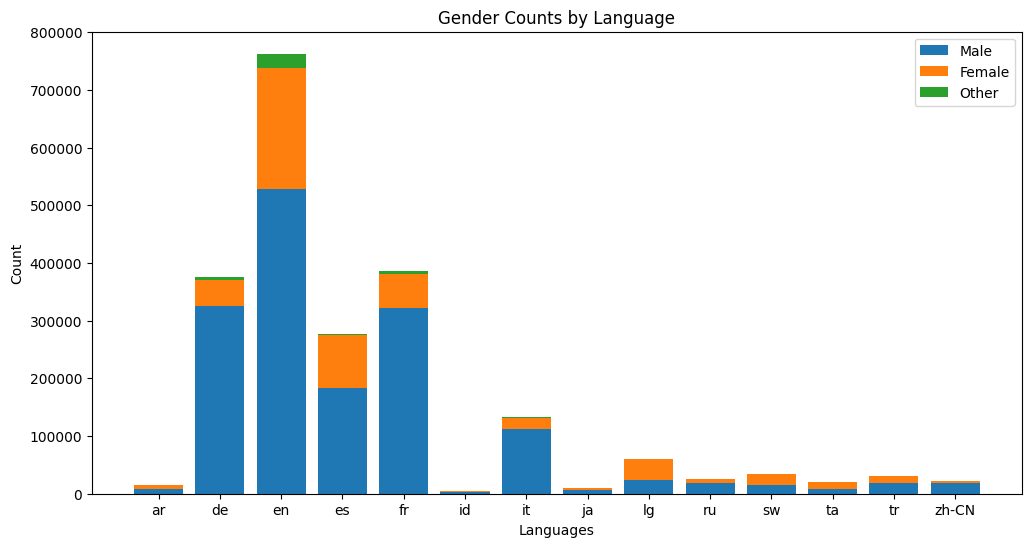

Language with the most unbalanced distribution : en


In [19]:
#Question 8

languages = []
male_counts = []
female_counts = []
other_counts = []

for lang, df in lang_data.items():
    languages.append(lang)
    gender_counts = df['gender'].value_counts()
    male_counts.append(gender_counts.get('male', 0))
    female_counts.append(gender_counts.get('female', 0))
    other_counts.append(gender_counts.get('other', 0))

# Create a bar chart
plt.figure(figsize=(12, 6))
plt.bar(languages, male_counts, label='Male')
plt.bar(languages, female_counts, bottom=male_counts, label='Female')
plt.bar(languages, other_counts, bottom=[sum(x) for x in zip(male_counts, female_counts)], label='Other')

# Add labels and legend
plt.xlabel('Languages')
plt.ylabel('Count')
plt.title('Gender Counts by Language')
plt.legend()

# Show the plot
plt.show()

gender_diff = [male - female for male, female in zip(male_counts, female_counts)]
ind = gender_diff.index(max(gender_diff))
print(f"Language with the most unbalanced distribution : {languages[ind]}")

In [20]:
#Question 9
for lang,df in lang_data.items():

    df_f = df[concatenated_df['gender'] == 'female'].copy()
    df_m = df[concatenated_df['gender'] == 'male'].copy()

    cumulative_duration_f = df_f.groupby(by="client_id")['duration[ms]'].sum().sort_values().cumsum()
    cumulative_duration_m = df_m.groupby(by="client_id")['duration[ms]'].sum().sort_values().cumsum()

    test_threshold = 60000 / 2
    train_threshold = 3.6e+6 / 2

    result_test = pd.concat([
        df_f[df_f["client_id"].isin(cumulative_duration_f[cumulative_duration_f <= test_threshold].index)],
        df_m[df_m["client_id"].isin(cumulative_duration_m[cumulative_duration_m <= test_threshold].index)]
    ])

    result_train = pd.concat([
        df_f[df_f["client_id"].isin(cumulative_duration_f[
            (cumulative_duration_f > test_threshold) & (cumulative_duration_f <= train_threshold)
        ].index)],
        df_m[df_m["client_id"].isin(cumulative_duration_m[
            (cumulative_duration_m > test_threshold) & (cumulative_duration_m <= train_threshold)
        ].index)]
    ])

result_train["duration[ms]"].cumsum()


C:\Users\anais\AppData\Local\Temp\ipykernel_2376\3355634270.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_f = df[concatenated_df['gender'] == 'female'].copy()
C:\Users\anais\AppData\Local\Temp\ipykernel_2376\3355634270.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_m = df[concatenated_df['gender'] == 'male'].copy()
C:\Users\anais\AppData\Local\Temp\ipykernel_2376\3355634270.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_f = df[concatenated_df['gender'] == 'female'].copy()
C:\Users\anais\AppData\Local\Temp\ipykernel_2376\3355634270.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_m = df[concatenated_df['gender'] == 'male'].copy()
C:\Users\anais\AppData\Local\Temp\ipykernel_2376\3355634270.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_f = df[concatenated_df['gender'] == 'female'].copy()
C:\U

767         2160
768         3996
769         5724
770         7704
771         9432
          ...   
39731    3503400
39781    3512400
40018    3514200
40019    3515748
40020    3525648
Name: duration[ms], Length: 662, dtype: int64

In [21]:
concatenated_df.to_csv("concatenated_df.csv")

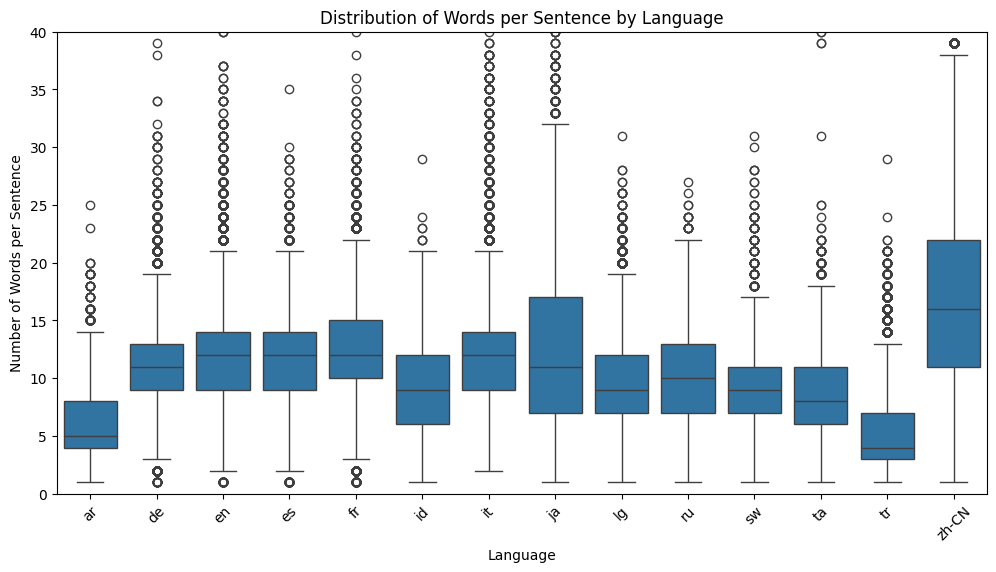

In [35]:
#Question 10
tokenizer = MosesTokenizer()
concatenated_df['sentence_word_count'] = concatenated_df['sentence'].apply(lambda x : len(tokenizer.tokenize(x, return_str=True).split()))


plt.figure(figsize=(12, 6))
ax = sns.boxplot(x='Language', y='sentence_word_count', data=concatenated_df)
plt.xticks(rotation=45)
plt.title('Distribution of Words per Sentence by Language')
plt.xlabel('Language')
plt.ylabel('Number of Words per Sentence')
ax.set(ylim=(0, 40))  

plt.show()


In [51]:
concatenated_df[concatenated_df['Language'] == 'en']['sentence_word_count'].head()

623040    10
623041    15
623042    13
623043     9
623044     9
Name: sentence_word_count, dtype: int64

In [56]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
tokens = tokenizer.tokenize("A street and a square are named after him.")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anais\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['street', 'square', 'named', '.']

In [63]:
# Remove stop words and count words
def count_no_stop(sentence,stop_words):
    tokens = tokenizer.tokenize(sentence,return_str=True),stop_words
    return Counter([word.lower() for word in tokens if word.lower() not in stop_words])


# Apply tokenization and stop word removal to the "sentence" column
concatenated_df['count_tokens_no_stop'] = concatenated_df['sentence'].apply(count_no_stop)

concatenated_df['count_tokens_no_stop'].head()

TypeError: count_no_stop() missing 1 required positional argument: 'stop_words'

In [62]:
count_no_stop(tokens,stop_words)

Counter({'street': 1, 'square': 1, 'named': 1, '.': 1})

In [61]:
concatenated_df[concatenated_df['Language'] == 'en']['word_counts_no_stop'].head()


623040    {' ': 9, 'r': 4, 'e': 6, 'n': 2, 'q': 1, 'u': ...
623041    {'h': 4, 'w': 2, 'e': 13, 'v': 1, 'r': 7, ' ':...
623042    {'n': 9, 'e': 8, 'g': 3, 'h': 1, 'b': 3, 'u': ...
623043    {'k': 1, 'r': 4, 'n': 3, ' ': 8, 'b': 2, 'u': ...
623044    {' ': 8, 'r': 3, 'e': 4, 'u': 1, 'l': 3, ',': ...
Name: word_counts_no_stop, dtype: object

In [43]:
# Define a function to get the top n words from a Counter
def get_top_n_words(counter, n=17):
    combined_counter = Counter()
    for c in counter:
        combined_counter.update(c)
    sorted_words = sorted(combined_counter.items(), key=lambda x: x[1], reverse=True)
    return [word for word, count in sorted_words[:n]]


language_most_frequent_words = language_most_frequent_words.apply(lambda x: get_top_n_words(x))
for lang, word_counts in language_most_frequent_words.items():
    print(f"Language: {lang}")
    for word, count in word_counts:
        print(f"{word}: {count}")
    print("\n")

Language: ar


ValueError: not enough values to unpack (expected 2, got 1)

In [34]:
#Question 12
#Print the total number of words for each language
print("total number of words for each language")
concatenated_df.groupby('Language')['sentence_word_count'].sum()

total number of words for each language


Language
ar         237832
de        6359896
en       12803621
es        3739451
fr        6523544
id          78576
it        2093518
ja         158177
lg         865161
ru         372543
sw         514743
ta         531237
tr         242705
zh-CN      673510
Name: sentence_word_count, dtype: int64

In [ ]:
#Question 2.1

vectorizer = TfidfVectorizer()


path = "../US_Inaugural_Addresses/"
for file_path in os.listdir(path):
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()
        president = lines[0].strip()
        year = lines[1].strip()
        discourse = lines[2].strip()
        data.append({"name": president, "year": year, "discourse": discourse})

df = pd.DataFrame(data)
tfidf_matrix = vectorizer.fit_transform(df['discourse'])
df['tf_idf'] = list(tfidf_matrix.toarray())

df


In [ ]:
# Step 2: Calculate cosine similarity between all pairs of speeches
similarity_matrix = cosine_similarity(tfidf_matrix)

# Step 3: Store the similarity scores in a square matrix
similarity_df = pd.DataFrame(similarity_matrix, columns=df['column_speeches'], index=df['row_speeches'])

# You now have a similarity matrix where rows and columns represent speeches,
# and the cell values represent cosine similarity scores.

# Add the similarity matrix to the original DataFrame
df = pd.concat([df, similarity_df], axis=1)

# Display the updated DataFrame
print(df)
